In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [33]:
# Read in a image from torchvision
img = torchvision.io.read_image("./sample_images/bro.jpg")
print(img.shape)
img = torch.tensor(img, dtype=torch.float)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

torch.Size([3, 1599, 899])
torch.Size([1599, 899])


C:\Users\karan\AppData\Local\Temp\ipykernel_1420\3098473836.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


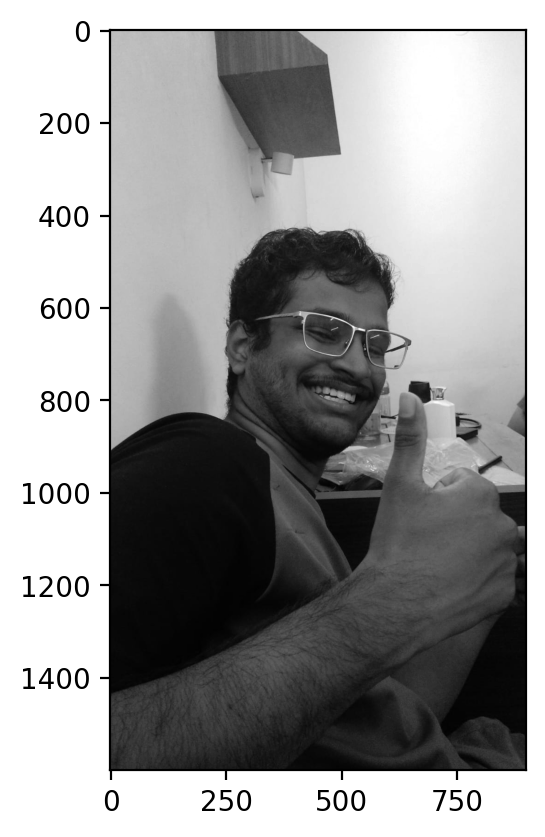

In [34]:
plt.imshow(img, cmap='gray')

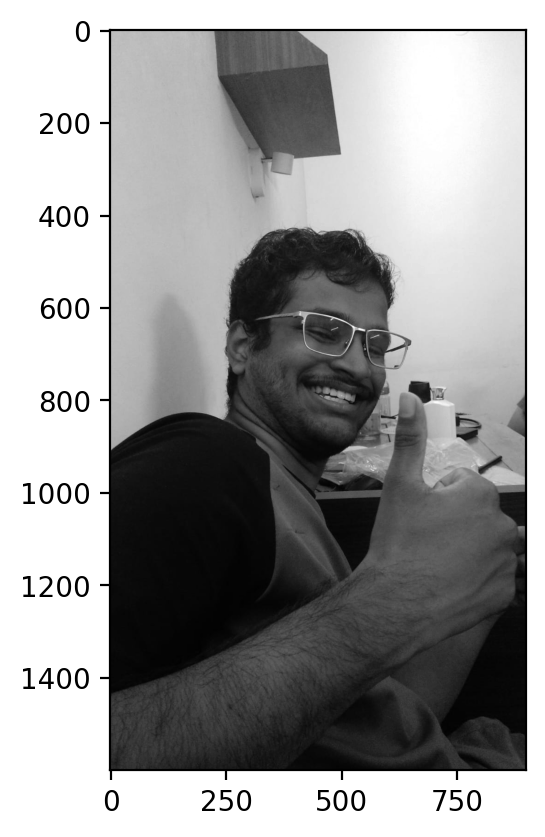

In [35]:
# crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
crop = img
crop.shape
plt.imshow(crop, cmap='gray')

In [36]:
# Mask the image with NaN values 
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

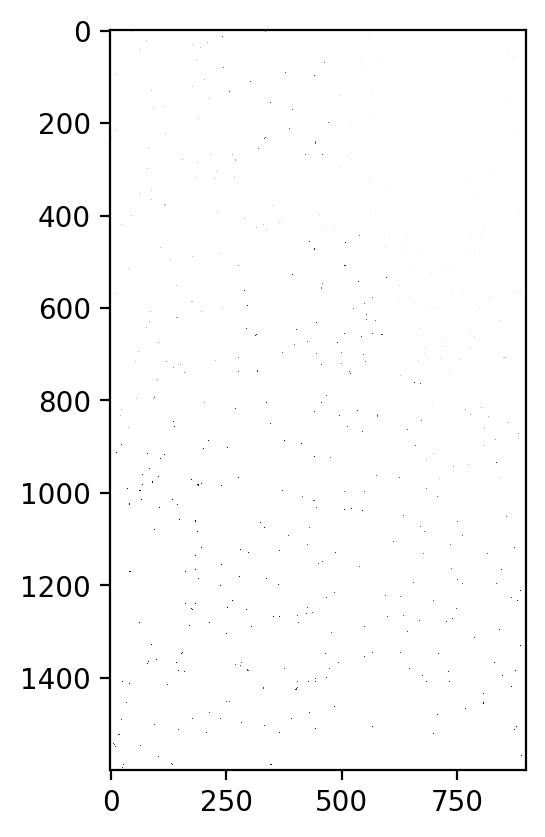

In [43]:
masked_img = mask_image(crop, 0.3)
masked_img[1].sum()
plt.imshow(masked_img[0], cmap='gray')


In [38]:
W, H, loss = factorize(masked_img[0], 50, device=device)

In [39]:
loss

tensor(6008.5645, grad_fn=<LinalgVectorNormBackward0>)

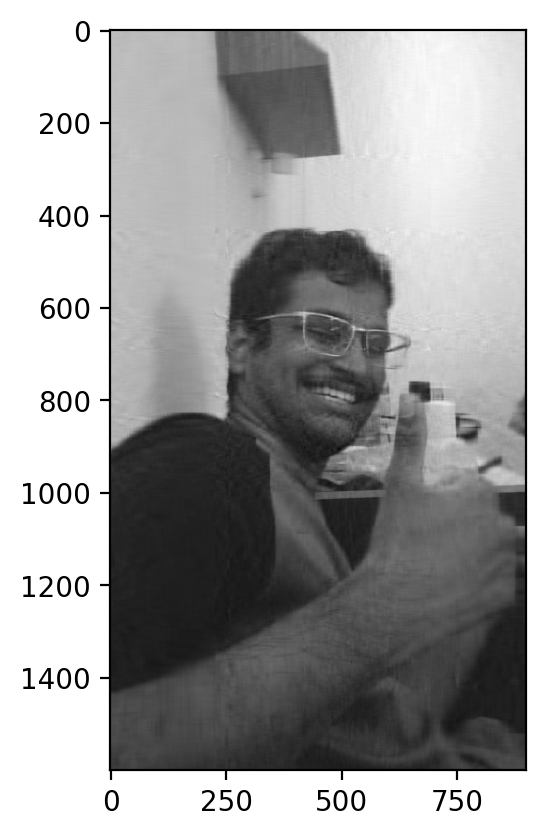

In [40]:
plt.imshow(torch.mm(W, H).cpu().detach().numpy(), cmap='gray')

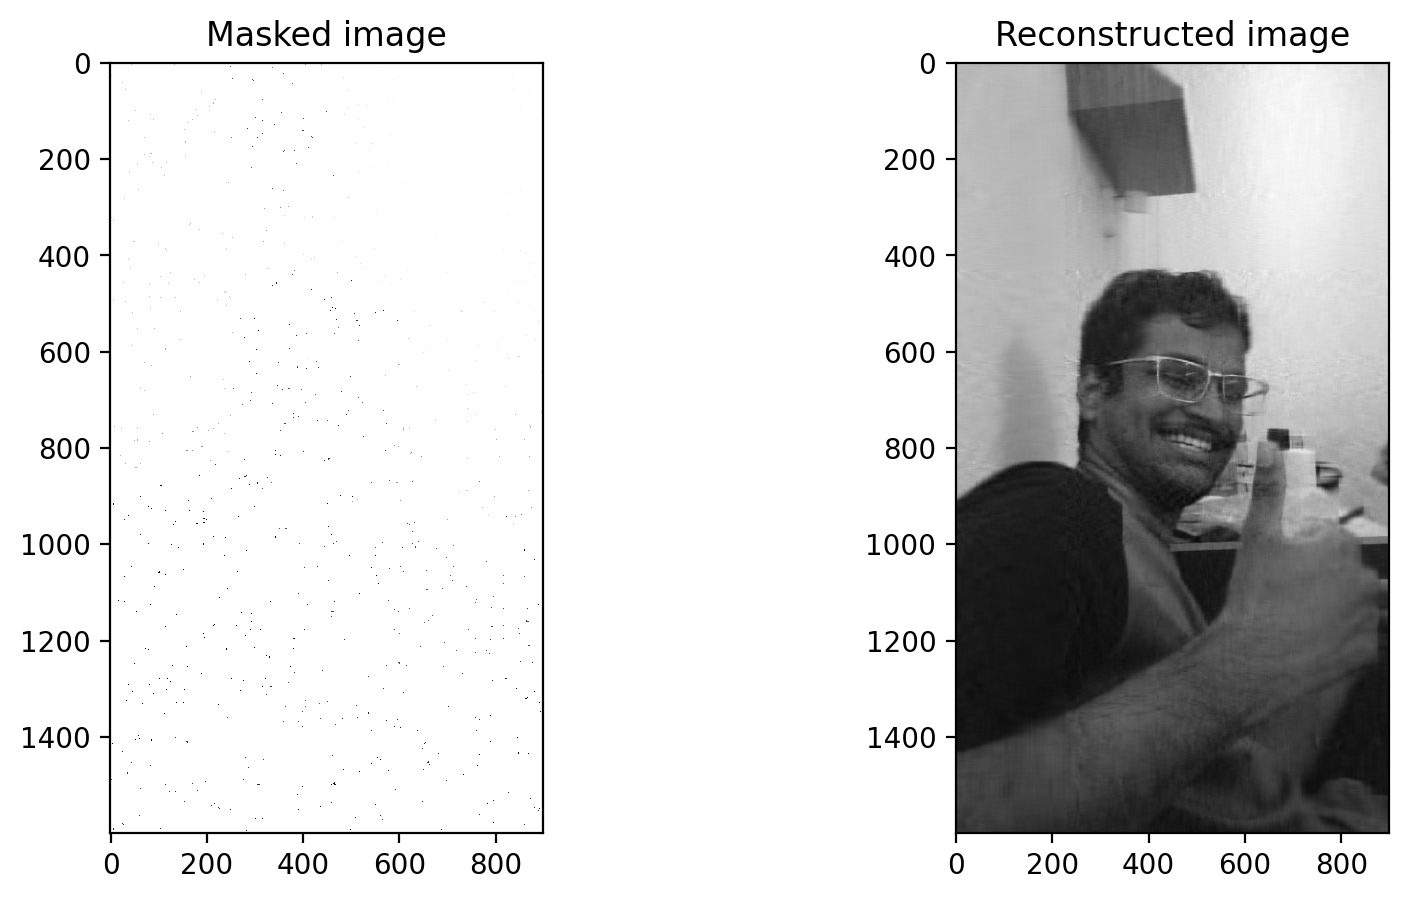

In [46]:
def plot_image_completion(prop=0.1, factors=50):
    masked_img, mask = mask_image(crop, prop)
    W, H, loss = factorize(masked_img, factors, device=device)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    reconstructed_img = torch.mm(W, H).cpu().detach().numpy()
    ax[0].imshow(masked_img, cmap='gray')
    ax[0].set_title("Masked image")
    ax[1].imshow(reconstructed_img, cmap='gray')
    ax[1].set_title("Reconstructed image")
    
plot_image_completion(0.3, 50)

In [42]:
# Now use matrix faactaorization to predict the ratings
# Create a class for the model

class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies, n_factors=20):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.movie_factors = nn.Embedding(n_movies, n_factors)

    def forward(self, user, movie):
        return (self.user_factors(user) * self.movie_factors(movie)).sum(1)      